# Install Librarires

In [ ]:
!pip install tensorflow
!pip install ablang
!pip install ablang2
!pip install tensorflow
!pip install tensorboardX
!pip install icn3dpy
!pip install jupyterlab
!jupyterhub labextension install jupyterlab_3dmol

In [85]:
# Import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import ablang #AbLang is a RoBERTa inspired language model trained on antibody sequences. 
import ablang2
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import icn3dpy
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

ModuleNotFoundError: No module named 'tensorflow.keras.wrappers'

In [86]:
print(tf.__version__)

2.15.0


In [75]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 6.0 MB/s eta 0:00:00
  Using cached regex-2023.12.25-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (40 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 87.8 MB/s eta 0:00:00:00:0100:01
Using cached regex-2023.12.25-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (785 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# Data prepration 

1. import data related to VH and VL sequence, and thier correspoding label, here is neutrialzing the antigen or not
2. generate embedding of the sequence: to this we first need to load pretained encoder generative models like ablang and ablang2. Then we prepared the sequence data in a format acceptable by these pretrained models.


## VH (Variable Heavy) and VL (Variable Light)
Antibodies, also known as immunoglobulins, are Y-shaped molecules composed of two identical heavy chains and two identical light chains. Each chain consists of variable (V) and constant (C) regions. The variable regions of the heavy and light chains (VH and VL, respectively) are critical for the antibody's specificity because they contain the antigen-binding site. This site binds to specific parts of an antigen, called epitopes, allowing the antibody to recognize and bind to a vast array of pathogens.

## VHH (Single Domain Antibodies)
VHH refers to a special type of antibody fragment derived from heavy-chain-only antibodies (HcAbs) found in camelids (camels, llamas, and alpacas). Unlike conventional antibodies, HcAbs do not have light chains, so their antigen-binding site consists solely of the variable domain of the heavy chain (VHH). VHH antibodies, also known as nanobodies, are much smaller than regular antibodies, which allows them to reach and bind to hidden epitopes that are inaccessible to conventional antibodies. Their small size, high stability, solubility, and ease of production in microbial systems make VHH antibodies particularly attractive for research, diagnostic, and therapeutic applications.

VHorVHH seems contain both heavy and light weight variable. ablang2_model reuires both VH and VL as input sequence to conduct embedding.

In [24]:
df = pd.read_csv("data/covabdab_all.csv")

In [25]:
df

,Name,Ab or Nb,Binds to,Doesn't Bind to,Neutralising Vs,Not Neutralising Vs,Protein + Epitope,Origin,VHorVHH,VL,...,Light J Gene,CDRH3,CDRL3,Structures,ABB Homology Model (if no structure),Sources,Date Added,Last Updated,Update Description,Notes/Following Up?
0,002-S21F2,Ab,SARS-CoV2_WT;SARS-CoV2_Alpha;SARS-CoV2_Beta;SA...,NaN,SARS-CoV2_WT;SARS-CoV2_Alpha;SARS-CoV2_Beta;SA...,NaN,S; RBD,B-cells; SARS-CoV2_WT Human Patient,ND,ND,...,ND,ARGEMTAVFGDY,QQYKILLTWT,Expected (7U0P+7UPL),NaN,"Sanjeev Kumar et al., 2022 (https://www.biorxi...","Jun 14, 2022","Jun 14, 2022",NaN,Awaiting release of structures in the PDB to g...
1,0304-2F8,Ab,SARS-CoV2_WT (weak),NaN,NaN,SARS-CoV2_WT,S; Unk,B-cells; SARS-CoV2_WT Human Patient,EVQLVQSGAEVSQPGESLKISCKGSGYSFTGYWISWVRQMPGKGLE...,EIVMTQSHTLLPVTPGEPASITCRSSQSLLHSNGYNYLDWYLQKPG...,...,IGKJ3 (Human),ARRGDGLYYYGMDV,MQALQTPQT,ND,NaN,"Xiangyang Chi et al., 2020 (https://science.sc...","Jun 23, 2020","Jun 23, 2020",NaN,Complete
2,0304-3H3,Ab,SARS-CoV2_WT,NaN,SARS-CoV2_WT,NaN,S; S2,B-cells; SARS-CoV2_WT Human Patient,EVQLVESGPGLVKPSETLSLTCTASGGSISTYYWSWIRQPPGKGLE...,DIVMTQSPATLSVSPEERATLSCRASQSVSSNLAWYQQKPGQAPRL...,...,IGKJ1 (Human),ARDRIAPVGKFFGWYFDL,QQYNKWPPWT,ND,NaN,"Xiangyang Chi et al., 2020 (https://science.sc...","Jun 23, 2020","Jun 23, 2020",NaN,Complete
3,0304-4A10,Ab,SARS-CoV2_WT,NaN,NaN,SARS-CoV2_WT,S; S2,B-cells; SARS-CoV2_WT Human Patient,EVQLVESGGGLVQPGGSLRLSCAASGFTFSTYAMHWVRQAPGKGLE...,EIVLTQSPDSLAVSLGERATINCRSSQSVLYSSNNKNYLAWYQQKP...,...,IGKJ3 (Human),ARSSSRGFDY,QQYYSSPYA,ND,NaN,"Xiangyang Chi et al., 2020 (https://science.sc...","Jun 23, 2020","Jun 23, 2020",NaN,Complete
4,0304-4A2,Ab,SARS-CoV2_WT,NaN,NaN,SARS-CoV2_WT,S; S1 non-RBD,B-cells; SARS-CoV2_WT Human Patient,EVQLVESGPGLVKPSETLSLTCAVSGDSTSSSSSYWDWIRQPPGKG...,EIVLTQSPDSLAVSLGERATINCKSSQSVLYSSNNKNYLAWYQQKP...,...,IGKJ1 (Human),ARELFTAVAGKGGIDY,HQYYNTPRT,ND,NaN,"Xiangyang Chi et al., 2020 (https://science.sc...","Jun 23, 2020","Jun 23, 2020",NaN,Complete
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10000,ZWC12,Ab,SARS-CoV2_WT;SARS-CoV2_Alpha;SARS-CoV2_Beta;SA...,NaN,SARS-CoV2_WT;SARS-CoV2_Alpha;SARS-CoV2_Beta;SA...,NaN,S; RBD,B-cells (SARS-CoV2 Vaccinated Human),ND,ND,...,IGKJ3 (Human),AKGELLWFGDLLHNWFDP,QQYDSWPGT,ND,NaN,"Xiangyang Chi et al., 2022 (https://www.nature...","Jul 26, 2022","Jul 26, 2022",NaN,Awaiting sequences in genbank.
10001,ZWC6,Ab,SARS-CoV2_WT;SARS-CoV2_Alpha;SARS-CoV2_Beta;SA...,SARS-CoV2_Omicron,SARS-CoV2_WT;SARS-CoV2_Alpha;SARS-CoV2_Beta;SA...,SARS-CoV2_Omicron,S; RBD,B-cells (SARS-CoV2 Vaccinated Human),EVQLVESGGGVVQPGTSLRLSCAASGFSFSHYVMYWVRQAPGKGLD...,AIRMTQSPPTLSLSPGERATLSCRASQSVTNYLVWYQQKPGQAPRL...,...,IGKJ3 (Human),AIHGGTYYYDKNILA,QQRSNWPPT,PDB entry 7WWM [PDB][SAbDab],NaN,CN113735970A (https://patents.google.com/paten...,"Jun 14, 2022","Jul 26, 2022",14th Jun '22: Added new structure. 26th Jul '2...,Complete
10002,ZWD11,Ab,SARS-CoV2_WT;SARS_CoV2_Alpha;SARS-CoV2_Beta;SA...,SARS-CoV2_Omicron-BA1,SARS-CoV2_WT;SARS_CoV2_Alpha;SARS-CoV2_Beta;SA...,SARS-CoV2_Omicron-BA1,S; RBD,B-cells (SARS-CoV2 Vaccinated Human),ND,ND,...,IGKJ4 (Human),ARDQADYYYGSGCIV,QQYSNTPLT,ND,NaN,"Xiangyang Chi et al., 2022 (https://www.nature...","Jul 26, 2022","Jul 26, 2022",NaN,Awaiting sequences in genbank.
10003,ZWD12,Ab,SARS-CoV2_WT;SARS-CoV2_Alpha;SARS-CoV2_Beta;SA...,NaN,SARS-CoV2_WT;SARS-CoV2_Alpha;SARS-CoV2_Beta;SA...,NaN,S; RBD,B-cells (SARS-CoV2 Vaccinated Human),EVQLVESGGGLVQPGGTLRLSCVASGFSFSNYWMSWVRQAPGKGLE...,DIVMTQTPSSLSLSPGDRATLSCRASENIINYLAWYQQRPGQSPRL...,...,IGKJ2 (Human),VKDRTDWELIRGYFGH,QQRIIWPPYT,PDB entry 7WWL [PDB][SAbDab],NaN,CN113735969A (https://patents.google.com/paten...,"Jan 31, 2022","Jun 14, 2022",14th Jun '22: Added new structure.,Complete


In [26]:
# get the heavy chain sequence "seqs", the neutralising data (0 or 1) "neutralising", and PDB IDs "pdbids"
seqsvh = []
seqsvl = []
neutralising = []
pdbids = []

frame_size = len(df.index)

# There are some problems in some sequences,let's try the first 3000 records for now
#MAXCNT = frame_size
MAXCNT = 3000

cnt = 0
for i in range(frame_size):
    if (cnt < MAXCNT and str(df.iloc[i]['Origin']).lower().find('human') != -1 and df.iloc[i]['VHorVHH'] != 'ND' and df.iloc[i]['VL'] != 'ND' 
       and not pd.isnull(df.iloc[i]['VL'])):
        seqsvh.append(df.iloc[i]['VHorVHH'])
        seqsvl.append(df.iloc[i]['VL'])
        # somehow the empty string became "nan"
        if(str(df.iloc[i]['Neutralising Vs']) != "nan"):
            neutralising.append(1)
        else:
            neutralising.append(0)
            
        if(str(df.iloc[i]['Structures']).find('PDB entry') != -1):
            pdbids.append(str(df.iloc[i]['Structures'])[10:14])
        else:
            pdbids.append('')
            
        cnt = cnt + 1

print ("Lines:", len(seqsvh))
print (seqsvh[0:2])
print (seqsvl[0:2])
print (neutralising[0:2])
print (pdbids[0:2])

Lines: 3000
['EVQLVQSGAEVSQPGESLKISCKGSGYSFTGYWISWVRQMPGKGLEWMGIIYPGDSDTKYTPSFQGQVTISTDKSINTAYLQWSSLKASDTAMYYCARRGDGLYYYGMDVWGQGTTVTVSS', 'EVQLVESGPGLVKPSETLSLTCTASGGSISTYYWSWIRQPPGKGLEWIGYIYYSGSTNYNPSLKSRVTISVDTSKNQFSLKLSSVTAADTAVYYCARDRIAPVGKFFGWYFDLWGRGTLVTVSS']
['EIVMTQSHTLLPVTPGEPASITCRSSQSLLHSNGYNYLDWYLQKPGQSPQLLIYLGSNRASGVPDRFSGSGSGTDFTLKISRVEAEDVGVYYCMQALQTPQTFGQGTKVDIK', 'DIVMTQSPATLSVSPEERATLSCRASQSVSSNLAWYQQKPGQAPRLLIYGASTRATGIPARFSGSGSGTEFTLTISSLQSEDFAVYYCQQYNKWPPWTFGQGTKVDIK']
[0, 1]
['', '']


# Data exploration
First we can compare the distibution of those data related to binidng and non binding and see if there is a different between them
We can use simple box plot or even PC to check it.

In [27]:
df = pd.DataFrame({'seqsvh': seqsvh, 'seqsvl':seqsvl, 'neutralising': neutralising})

<Axes: >

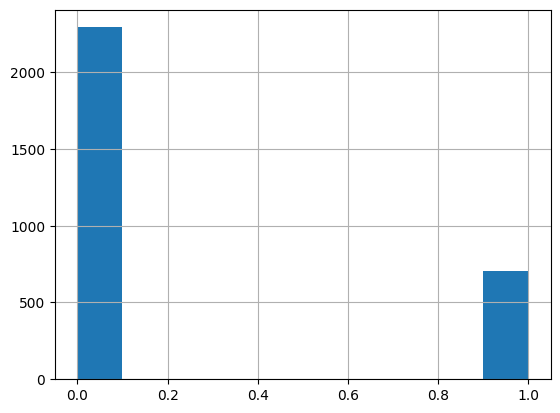

In [28]:
df['neutralising'].hist()

In [29]:
# distibution of two dataset
# PC1 and 2

In [30]:
df

,seqsvh,seqsvl,neutralising
0,EVQLVQSGAEVSQPGESLKISCKGSGYSFTGYWISWVRQMPGKGLE...,EIVMTQSHTLLPVTPGEPASITCRSSQSLLHSNGYNYLDWYLQKPG...,0
1,EVQLVESGPGLVKPSETLSLTCTASGGSISTYYWSWIRQPPGKGLE...,DIVMTQSPATLSVSPEERATLSCRASQSVSSNLAWYQQKPGQAPRL...,1
2,EVQLVESGGGLVQPGGSLRLSCAASGFTFSTYAMHWVRQAPGKGLE...,EIVLTQSPDSLAVSLGERATINCRSSQSVLYSSNNKNYLAWYQQKP...,0
3,EVQLVESGPGLVKPSETLSLTCAVSGDSTSSSSSYWDWIRQPPGKG...,EIVLTQSPDSLAVSLGERATINCKSSQSVLYSSNNKNYLAWYQQKP...,0
4,QVQLVQSGGGVVQPGRSLRLSCAAPGFTFSSYGMHWVRQAPGKGLE...,DIVMTQSPATLSLSPGERATLSCRASQSVSSYLAWYQQKPGQAPRL...,0
...,...,...,...
2995,QVQLQQWGAGLLKPSETLSLTCAVDGASFGGYYWSWIRQPPGKGLE...,QSALTQPASVSGSPGQSITISCTGTSSDIGRFYYVSWYQHHPGKAP...,0
2996,EVQLLESGGGLVQPGGSLRLSCAASGFTFSNFAMIWVRQAPGKGLE...,DIQMTQSPSSLSASVGDRVTIFCQASQDVSNYLNWYQQKPGKAPKL...,1
2997,EVQLVESGGGLVKPGGSLRLSCAASAFTFSTDSMSWVRQAPGKGLA...,QPVLTQSSSASASLGSSVKLTCTLSGGHTSSIIAWHQQQPGKAPRY...,1
2998,QIQLQQSGPGLVKPSQTLSLTCALSGDSVSSDSSAWNWIRQSPSRG...,QSALTQPASVSGSPGQSITFSCTGTSSDVGDYNYVSWYQQHPGKAP...,1


In [31]:
neutralising.count(1)

708

In [32]:
neutralising.count(0)

2292

## Ablang 

In [33]:
# heavy chain sequence
# heavy_ablang = ablang.pretrained("heavy")
# heavy_ablang.freeze()

In [34]:
# use the "Seq-coding" example to get an array for each sequence
# seqcodings = heavy_ablang(seqs, mode='seqcoding')

## Ablang2

In [35]:
# load Ablang2 model to create embedding the sequence
ablang2_model = ablang2.pretrained()

In [36]:
# Ablang2 data format [VH sequence, VL sequence]
# Test the model embedding
seq1 = [
    'EVQLLESGGEVKKPGASVKVSCRASGYTFRNYGLTWVRQAPGQGLEWMGWISAYNGNTNYAQKFQGRVTLTTDTSTSTAYMELRSLRSDDTAVYFCARDVPGHGAAFMDVWGTGTTVTVSS', # VH sequence
    'DIQLTQSPLSLPVTLGQPASISCRSSQSLEASDTNIYLSWFQQRPGQSPRRLIYKISNRDSGVPDRFSGSGSGTHFTLRISRVEADDVAVYYCMQGTHWPPAFGQGTKVDIK' # VL sequence
]
seq2 = [
    'EVQLLESGGEVKKPGASVKVSCRASGYTFRNYGLTWVRQAPGQGLEWMGWISAYNGNTNYAQKFQGRVTLTTDTSTSTAYMELRSLRSDDTAVYFCARDVPGHGAAFMDVWGTGTT',
    'PVTLGQPASISCRSSQSLEASDTNIYLSWFQQRPGQSPRRLIYKISNRDSGVPDRFSGSGSGTHFTLRISRVEADDVAVYYCMQGTHWPPAFGQGTKVDIK'
]
seq3 = [
    'EVQLLESGGEVKKPGASVKVSCRASGYTFRNYGLTWVRQAPGQGLEWMGWISAYNGNTNYAQKFQGRVTLTTDTSTSTAYMELRSLRSDDTAVYFCARDVPGHGAAFMDVWGTGTTVTVSS',
    '' # The VL sequence is not known, so an empty string is left instead. 
]
seq4 = [
    '',
    'DIQLTQSPLSLPVTLGQPASISCRSSQSLEASDTNIYLSWFQQRPGQSPRRLIYKISNRDSGVPDRFSGSGSGTHFTLRISRVEADDVAVYYCMQGTHWPPAFGQGTKVDIK'
]
seq5 = [
    'EVQ***SGGEVKKPGASVKVSCRASGYTFRNYGLTWVRQAPGQGLEWMGWISAYNGNTNYAQKFQGRVTLTTDTSTSTAYMELRSLRSDDTAVYFCAR**PGHGAAFMDVWGTGTTVTVSS', # (*) is used to mask certain residues
    'DIQLTQSPLSLPVTLGQPASISCRSS*SLEASDTNIYLSWFQQRPGQSPRRLIYKI*NRDSGVPDRFSGSGSGTHFTLRISRVEADDVAVYYCMQGTHWPPAFGQGTKVDIK'
]

all_seqs = [seq1, seq2, seq3, seq4, seq5]
only_both_chains_seqs = [seq1, seq2, seq5]
encoded = ablang2_model(all_seqs, mode='seqcoding')

In [37]:
df['seq'] = df.apply(lambda row: [row['seqsvh'], row['seqsvl']], axis=1)
df

,seqsvh,seqsvl,neutralising,seq
0,EVQLVQSGAEVSQPGESLKISCKGSGYSFTGYWISWVRQMPGKGLE...,EIVMTQSHTLLPVTPGEPASITCRSSQSLLHSNGYNYLDWYLQKPG...,0,[EVQLVQSGAEVSQPGESLKISCKGSGYSFTGYWISWVRQMPGKGL...
1,EVQLVESGPGLVKPSETLSLTCTASGGSISTYYWSWIRQPPGKGLE...,DIVMTQSPATLSVSPEERATLSCRASQSVSSNLAWYQQKPGQAPRL...,1,[EVQLVESGPGLVKPSETLSLTCTASGGSISTYYWSWIRQPPGKGL...
2,EVQLVESGGGLVQPGGSLRLSCAASGFTFSTYAMHWVRQAPGKGLE...,EIVLTQSPDSLAVSLGERATINCRSSQSVLYSSNNKNYLAWYQQKP...,0,[EVQLVESGGGLVQPGGSLRLSCAASGFTFSTYAMHWVRQAPGKGL...
3,EVQLVESGPGLVKPSETLSLTCAVSGDSTSSSSSYWDWIRQPPGKG...,EIVLTQSPDSLAVSLGERATINCKSSQSVLYSSNNKNYLAWYQQKP...,0,[EVQLVESGPGLVKPSETLSLTCAVSGDSTSSSSSYWDWIRQPPGK...
4,QVQLVQSGGGVVQPGRSLRLSCAAPGFTFSSYGMHWVRQAPGKGLE...,DIVMTQSPATLSLSPGERATLSCRASQSVSSYLAWYQQKPGQAPRL...,0,[QVQLVQSGGGVVQPGRSLRLSCAAPGFTFSSYGMHWVRQAPGKGL...
...,...,...,...,...
2995,QVQLQQWGAGLLKPSETLSLTCAVDGASFGGYYWSWIRQPPGKGLE...,QSALTQPASVSGSPGQSITISCTGTSSDIGRFYYVSWYQHHPGKAP...,0,[QVQLQQWGAGLLKPSETLSLTCAVDGASFGGYYWSWIRQPPGKGL...
2996,EVQLLESGGGLVQPGGSLRLSCAASGFTFSNFAMIWVRQAPGKGLE...,DIQMTQSPSSLSASVGDRVTIFCQASQDVSNYLNWYQQKPGKAPKL...,1,[EVQLLESGGGLVQPGGSLRLSCAASGFTFSNFAMIWVRQAPGKGL...
2997,EVQLVESGGGLVKPGGSLRLSCAASAFTFSTDSMSWVRQAPGKGLA...,QPVLTQSSSASASLGSSVKLTCTLSGGHTSSIIAWHQQQPGKAPRY...,1,[EVQLVESGGGLVKPGGSLRLSCAASAFTFSTDSMSWVRQAPGKGL...
2998,QIQLQQSGPGLVKPSQTLSLTCALSGDSVSSDSSAWNWIRQSPSRG...,QSALTQPASVSGSPGQSITFSCTGTSSDVGDYNYVSWYQQHPGKAP...,1,[QIQLQQSGPGLVKPSQTLSLTCALSGDSVSSDSSAWNWIRQSPSR...


In [38]:
seqs = list(df['seq'])
seqsvh_list = [[item, ''] for item in seqsvh]
seqsvl_list = [['', item] for item in seqsvl]

In [39]:
non_string_values = [item for item in seqsvl if not isinstance(item, str)]
non_string_values

[]

In [53]:
# prepare the sequence in a format that can be read by ablang2 model
seqcodings = ablang2_model(seqs, mode='seqcoding')
print("The output shape of the seq-codings:", seqcodings.shape)
print(seqcodings)

The output shape of the seq-codings: (3000, 480)
[[-0.20339753  0.24752703  0.08483118 ...  0.20981445 -0.12832902
  -0.09889554]
 [-0.32648866  0.26106842  0.184011   ...  0.1755036  -0.19497609
  -0.1738531 ]
 [-0.30553812  0.08313523  0.10455568 ...  0.22529813 -0.13755226
  -0.17712779]
 ...
 [-0.24408736  0.1386824  -0.0065362  ...  0.17710072 -0.11731781
  -0.16415748]
 [-0.18310766  0.02512652  0.07194669 ...  0.12494069 -0.1937089
  -0.16352598]
 [-0.18434102  0.04303722 -0.03622567 ...  0.2049059  -0.13858666
  -0.19174961]]


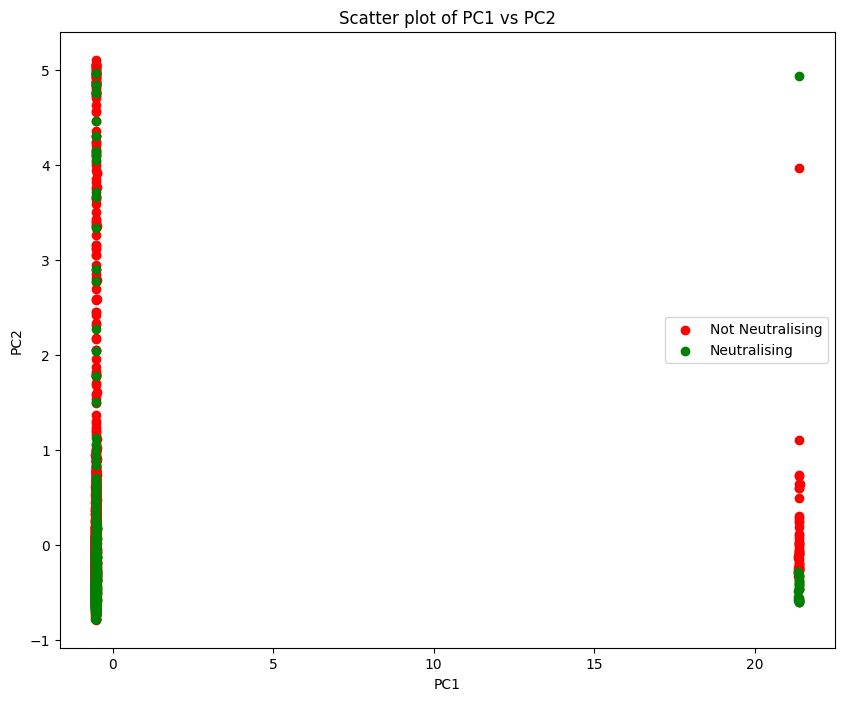

In [55]:
# Perform PCA with the desired number of components (let's say 2 components for visualization)
num_components = 2
pca = PCA(n_components=num_components)
pca_result = pca.fit_transform(seqcodings)

# Create a DataFrame to store the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i + 1}' for i in range(num_components)])

# # Add the neutralising columns back to the PCA DataFrame
pca_df['neutralising'] = neutralising

# # Plot the PCA results
plt.figure(figsize=(10, 8))
plt.scatter(pca_df['PC1'][pca_df['neutralising'] == 0], pca_df['PC2'][pca_df['neutralising'] == 0], color='r', label='Not Neutralising')
plt.scatter(pca_df['PC1'][pca_df['neutralising'] == 1], pca_df['PC2'][pca_df['neutralising'] == 1], color='g', label='Neutralising')
plt.title('Scatter plot of PC1 vs PC2')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

In [56]:
pca_df.head()

,PC1,PC2,neutralising
0,-0.511791,-0.490360,0
1,-0.507727,-0.365473,1
2,-0.528354,-0.282361,0
3,-0.522685,-0.439243,0
4,-0.521960,-0.242844,0


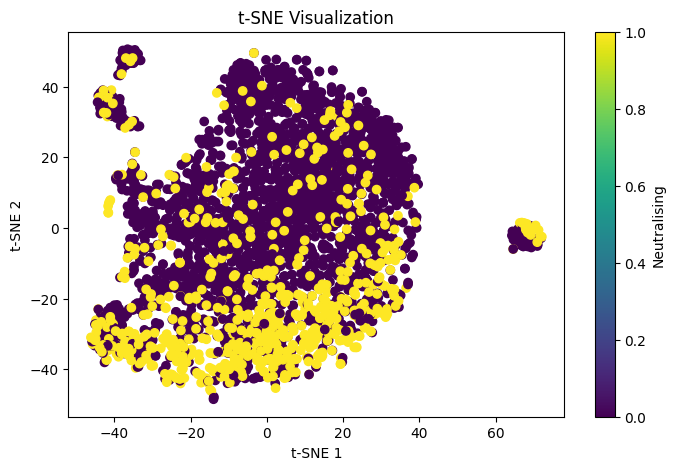

In [57]:
# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(seqcodings)

# Plotting
plt.figure(figsize=(8, 5))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=df['neutralising'], cmap='viridis')
plt.colorbar(label='Neutralising')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Visualization')
plt.show()

VHorVHH seems contain both heavy and light weight variable. ablang2_model reuires both VH and VL as input sequence to conduct embedding. 

# Modeling
Simple FC with binary classification can be used to for training the model.

To develop a good ML model, we should consider a few things:
1) data imbalance
2) necessary operation to balance the dataset
3) divide data to train, validate, and test. The train and validation dataset will be used to hyperparameter tuning of the model

In machine learning, balancing a dataset is important because models can be biased towards the more common class in an imbalanced dataset, leading to poor generalization.

## 1) Changing the Dataset:
- Down-sampling: Reducing the number of examples in the overrepresented class to match the underrepresented class.
- Oversampling: Increasing the number of examples in the underrepresented class by duplicating existing examples.
- Generate Synthetic Data: Creating new, synthetic examples of the underrepresented class, commonly using algorithms like SMOTE (Synthetic Minority Over-sampling Technique).

## 2) Training on Imbalanced Dataset and Calibrating:
- Train on Imbalanced Dataset: We can train our model on an imbalanced dataset but use metrics that are insensitive to class imbalance, like the area under the ROC curve (AUC-ROC).
- Model Calibration: After training, you can calibrate the model's predictions to improve probability estimates. This can involve techniques like Platt scaling or isotonic regression which adjust the decision threshold to account for the imbalance. Calibration is typically done on a separate validation set that reflects the true class distribution.
                                
                                                                                                                Calibrating a model after training on an imbalanced dataset can help adjust the prediction probabilities to be more reflective of the true underlying class distribution. This is especially useful when the cost of false negatives is different from the cost of false positives.

In [79]:
# This split ensures balanced classes in the train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    seqcodings, neutralising, test_size=0.1, random_state=0, stratify=neutralising
)

In [80]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [87]:
!pip install -q -U keras-tuner

In [88]:
import keras_tuner as kt

In [ ]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [93]:
import keras
# we need to perform the hyper parameter tunning 
# Define the model builder function
def model_builder(hp):
    model = keras.Sequential()
    # Tune the number of units in the first Dense layer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_units = hp.Choice('hp_units', values=[6, 12, 24]) 
    model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [95]:
# parameters = {
#     'batch_size': [32, 64],
#     'epochs': [50, 100],
#     'hidden_layer_units': [6, 12, 24],
#     'activation': ['relu', 'tanh']
# }

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir')
# Use StratifiedKFold to ensure balanced distribution in each fold
# stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
tuner.search(X_train, y_train, epochs=50, validation_split=0.2)

# grid_search = GridSearchCV(estimator=model, param_grid=parameters, n_jobs=-1, cv=stratified_kfold, scoring='accuracy')

# grid_search.fit(X_train, y_train)


# print("Best Parameters:", grid_search.best_params_)
# print("Best Accuracy:", grid_search.best_score_)

Trial 2 Complete [00h 00m 00s]

Best val_accuracy So Far: None
Total elapsed time: 00h 00m 01s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
12                |6                 |hp_units
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/site-packages/keras_tuner/src/engine/base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.11/site-packages/keras_tuner/src/engine/base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/site-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/site-packages/ke

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/site-packages/keras_tuner/src/engine/base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.11/site-packages/keras_tuner/src/engine/base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/site-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/site-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/site-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.11/site-packages/keras/src/engine/data_adapter.py", line 1776, in train_validation_split
    raise ValueError(
ValueError: `validation_split` is only supported for Tensors or NumPy arrays, found following types in the input: [<class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>]


In [58]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(seqcodings, neutralising, test_size = 0.2, random_state = 0)

In [59]:
# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [60]:
#Initializing the ANN
ann = tf.keras.models.Sequential()
# Adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
# Adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
# Adding the output layer
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
# Compiling the ANN
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [61]:
# Training the ANN on the Training set
X_train = np.array(X_train)
y_train = np.array(y_train)
ann.fit(X_train, y_train, batch_size = 32, epochs = 100)

Epoch 1/100
75/75 [==============================] - 1s 1ms/step - loss: 0.5086 - accuracy: 0.7571
Epoch 2/100
75/75 [==============================] - 0s 967us/step - loss: 0.4354 - accuracy: 0.7921
Epoch 3/100
75/75 [==============================] - 0s 875us/step - loss: 0.4219 - accuracy: 0.8112
Epoch 4/100
75/75 [==============================] - 0s 874us/step - loss: 0.4139 - accuracy: 0.8087
Epoch 5/100
75/75 [==============================] - 0s 865us/step - loss: 0.4006 - accuracy: 0.8208
Epoch 6/100
75/75 [==============================] - 0s 873us/step - loss: 0.3942 - accuracy: 0.8188
Epoch 7/100
75/75 [==============================] - 0s 866us/step - loss: 0.3863 - accuracy: 0.8250
Epoch 8/100
75/75 [==============================] - 0s 862us/step - loss: 0.3790 - accuracy: 0.8233
Epoch 9/100
75/75 [==============================] - 0s 868us/step - loss: 0.3749 - accuracy: 0.8313
Epoch 10/100
75/75 [==============================] - 0s 871us/step - loss: 0.3669 - accuracy

In [62]:
print ("len:", len(X_train), X_train)
print ("len:", len(X_test), X_test)
print ("len:", len(y_test), y_test)

len: 2400 [[-4.40299348e-01 -1.61041762e-01  1.55773137e-04 ...  1.17796181e-01
  -2.29083773e-01  2.22731309e-01]
 [-5.78240695e-01 -2.38488613e-01 -3.52819073e-01 ... -1.05607392e+00
  -2.87903898e-01 -3.13696474e-01]
 [-4.50342649e-01 -2.50935967e-01  4.28013123e-01 ...  1.17297051e-01
  -3.74435454e-01  4.40619453e-02]
 ...
 [-4.90615314e-01 -5.94598222e-01  8.70912673e-01 ... -2.51878324e-01
  -5.78352347e-01 -2.66882580e-03]
 [-3.78144888e-01  1.23366007e-02 -1.25321708e-01 ... -3.57416594e-01
   2.08125667e-01 -4.42573302e-01]
 [-1.42276382e-01  3.67689732e-01 -4.75093276e-02 ... -3.23515467e-01
  -1.81247907e-01 -2.34414686e-01]]
len: 600 [[-0.08421212  0.15263995 -0.03669835 ... -0.49181374 -0.27369908
  -0.02906037]
 [-0.38025024 -0.1986896  -0.5212828  ... -0.00703795  0.15936375
  -0.40689976]
 [-0.03047066 -0.05690114 -0.84333506 ...  0.67044337  0.29914297
   0.041352  ]
 ...
 [ 0.28156758  0.6912133  -0.49774876 ... -1.36847853 -0.66065106
  -0.73340898]
 [-0.38404288  0

In [63]:
# Predicting the Test set results
y_pred = ann.predict(X_test)
y_pred = (y_pred > 0.5)
#print ("len:", len(y_pred), y_pred)
#print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

19/19 [==============================] - 0s 721us/step


In [64]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[416  71]
 [ 57  56]]


0.7866666666666666

In [67]:
seqs[0]

['EVQLVQSGAEVSQPGESLKISCKGSGYSFTGYWISWVRQMPGKGLEWMGIIYPGDSDTKYTPSFQGQVTISTDKSINTAYLQWSSLKASDTAMYYCARRGDGLYYYGMDVWGQGTTVTVSS',
 'EIVMTQSHTLLPVTPGEPASITCRSSQSLLHSNGYNYLDWYLQKPGQSPQLLIYLGSNRASGVPDRFSGSGSGTDFTLKISRVEAEDVGVYYCMQALQTPQTFGQGTKVDIK']

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

def build_classifier(optimizer='adam'):
    classifier = tf.keras.models.Sequential()
    classifier.add(tf.keras.layers.Dense(units=6, activation='relu'))
    classifier.add(tf.keras.layers.Dense(units=6, activation='relu'))
    classifier.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    classifier.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return classifier

model = KerasClassifier(build_fn=build_classifier)
parameters = {'batch_size': [25, 32],
              'epochs': [100, 200],
              'optimizer': ['adam', 'rmsprop']}
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=10)
grid_search = grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

In [70]:
# show 3D structure
offset = int(MAXCNT * 0.8)
matchCnt = sum([1 for pred, test in zip(y_pred, y_test) if pred == test])
totalCnt = len(y_pred)

# Find the first non-empty pdbid and its sequence
for i, pdbid in enumerate(pdbids[offset:], start=offset):
    if pdbid:  # Checks if pdbid is not empty
        seq = seqs[i]
        print(f"PDB ID: {pdbid}, seq: {seq}")

        idStr = f'mmdbid={pdbid}'
        # Ensure seq is a string for concatenation
        seqStr = ''.join(seq) if isinstance(seq, list) else seq
        cmdStr = f'select :{seqStr} | name test; color F00; style proteins sphere'
        view = icn3dpy.view(q=idStr, command=cmdStr)
        view
        break  # Exit the loop after the first match

print(f"totalCnt: {totalCnt}, matchCnt: {matchCnt}, Matched ratio: {matchCnt/totalCnt}")


PDB ID: 7M7B, seq: ['QVQLQQWGAGLLKPSETLSLTCAVYGGSFSGYYWSWIRQPPGKGLEWIGEINHSGSTNYNPSLKSRVTISVDTSKNQFSLKLSSVTAADTAVYYCARRWWLRGAFDIWGQGTTVTVSS', 'NFMLTQPHSVSASPGKTVTIPCTGSSGNIASNYVQWYQQRPGSAPTTVIYEDNQRPSGVPDRFSGSIDSSSNSASLTISGLKTEDEADYYCQSYDNNIQVFGGGTKLTVL']
totalCnt: 600, matchCnt: 472, Matched ratio: 0.7866666666666666


In [71]:
idStr = 'mmdbid=' + pdbid
cmdStr = 'select :' + seqStr + ' | name test; color F00; style proteins sphere'
print (idStr, cmdStr)

mmdbid=7M7B select :QVQLQQWGAGLLKPSETLSLTCAVYGGSFSGYYWSWIRQPPGKGLEWIGEINHSGSTNYNPSLKSRVTISVDTSKNQFSLKLSSVTAADTAVYYCARRWWLRGAFDIWGQGTTVTVSSNFMLTQPHSVSASPGKTVTIPCTGSSGNIASNYVQWYQQRPGSAPTTVIYEDNQRPSGVPDRFSGSIDSSSNSASLTISGLKTEDEADYYCQSYDNNIQVFGGGTKLTVL | name test; color F00; style proteins sphere


In [72]:
view = icn3dpy.view(q=idStr,command=cmdStr)
view

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the extension: 
 jupyter labextension install jupyterlab_3dmol